# Import Statements

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import time as timer
import pickle
import sys
import os

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# Preprocessing

## Repackaging Data

In [24]:
repackage = False
if repackage:
    #Find all files in the data folder
    data_folder = 'FullData'
    data_files = [f for f in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, f))]
    print(f'Found {len(data_files)} files in {data_folder} folder.')
    
    #Extract labels from filenames
    labels = [f.split('_')[3][:-4] for f in data_files]
    print(f'Labels: {labels}')
    
    #Construct data array, labels array
    data_list = []
    label_list = []
    for i, f in enumerate(data_files):
        with open(os.path.join(data_folder, f), 'rb') as file:
            data = np.load(file)
            data_list.append(data)
            num_samples = data.shape[0]
            label_list.extend([labels[i]]*num_samples)
    
    #Convert to numpy arrays
    data_array = np.vstack(data_list)
    label_array = np.array(label_list)
    print(f'\nData shape: {data_array.shape[0]:,}, Labels shape: {label_array.shape[0]:,}')
    
    #Write to pickle file
    with open('FullData.pkl', 'wb') as f:
        pickle.dump((data_array, label_array), f)
    print('\nData repackaged and saved to FullData.pkl')

## Loading In Data

In [25]:
#Load data from pickle file
with open('FullData.pkl', 'rb') as f:
	data_array, label_array = pickle.load(f)
print(f'\nLoaded data from FullData.pkl: Data shape: {data_array.shape[0]:,}, Labels shape: {label_array.shape[0]:,}')

#Retrieve unique classes
classes = np.unique(label_array)
print(f'\nClasses: {classes}')


Loaded data from FullData.pkl: Data shape: 6,959,130, Labels shape: 6,959,130

Classes: ['ant' 'bat' 'bear' 'bee' 'bird' 'butterfly' 'camel' 'cat' 'cow' 'crab'
 'crocodile' 'dog' 'dolphin' 'dragon' 'duck' 'elephant' 'fish' 'flamingo'
 'frog' 'giraffe' 'hedgehog' 'horse' 'kangaroo' 'lion' 'lobster' 'monkey'
 'mosquito' 'mouse' 'octopus' 'owl' 'panda' 'parrot' 'penguin' 'pig'
 'rabbit' 'raccoon' 'rhinoceros' 'scorpion' 'sea turtle' 'shark' 'sheep'
 'snail' 'snake' 'spider' 'squirrel' 'swan' 'tiger' 'whale' 'zebra']


## Analyzing Class Breakdown

Text(0.5, 1.0, 'Class Distribution Histogram')

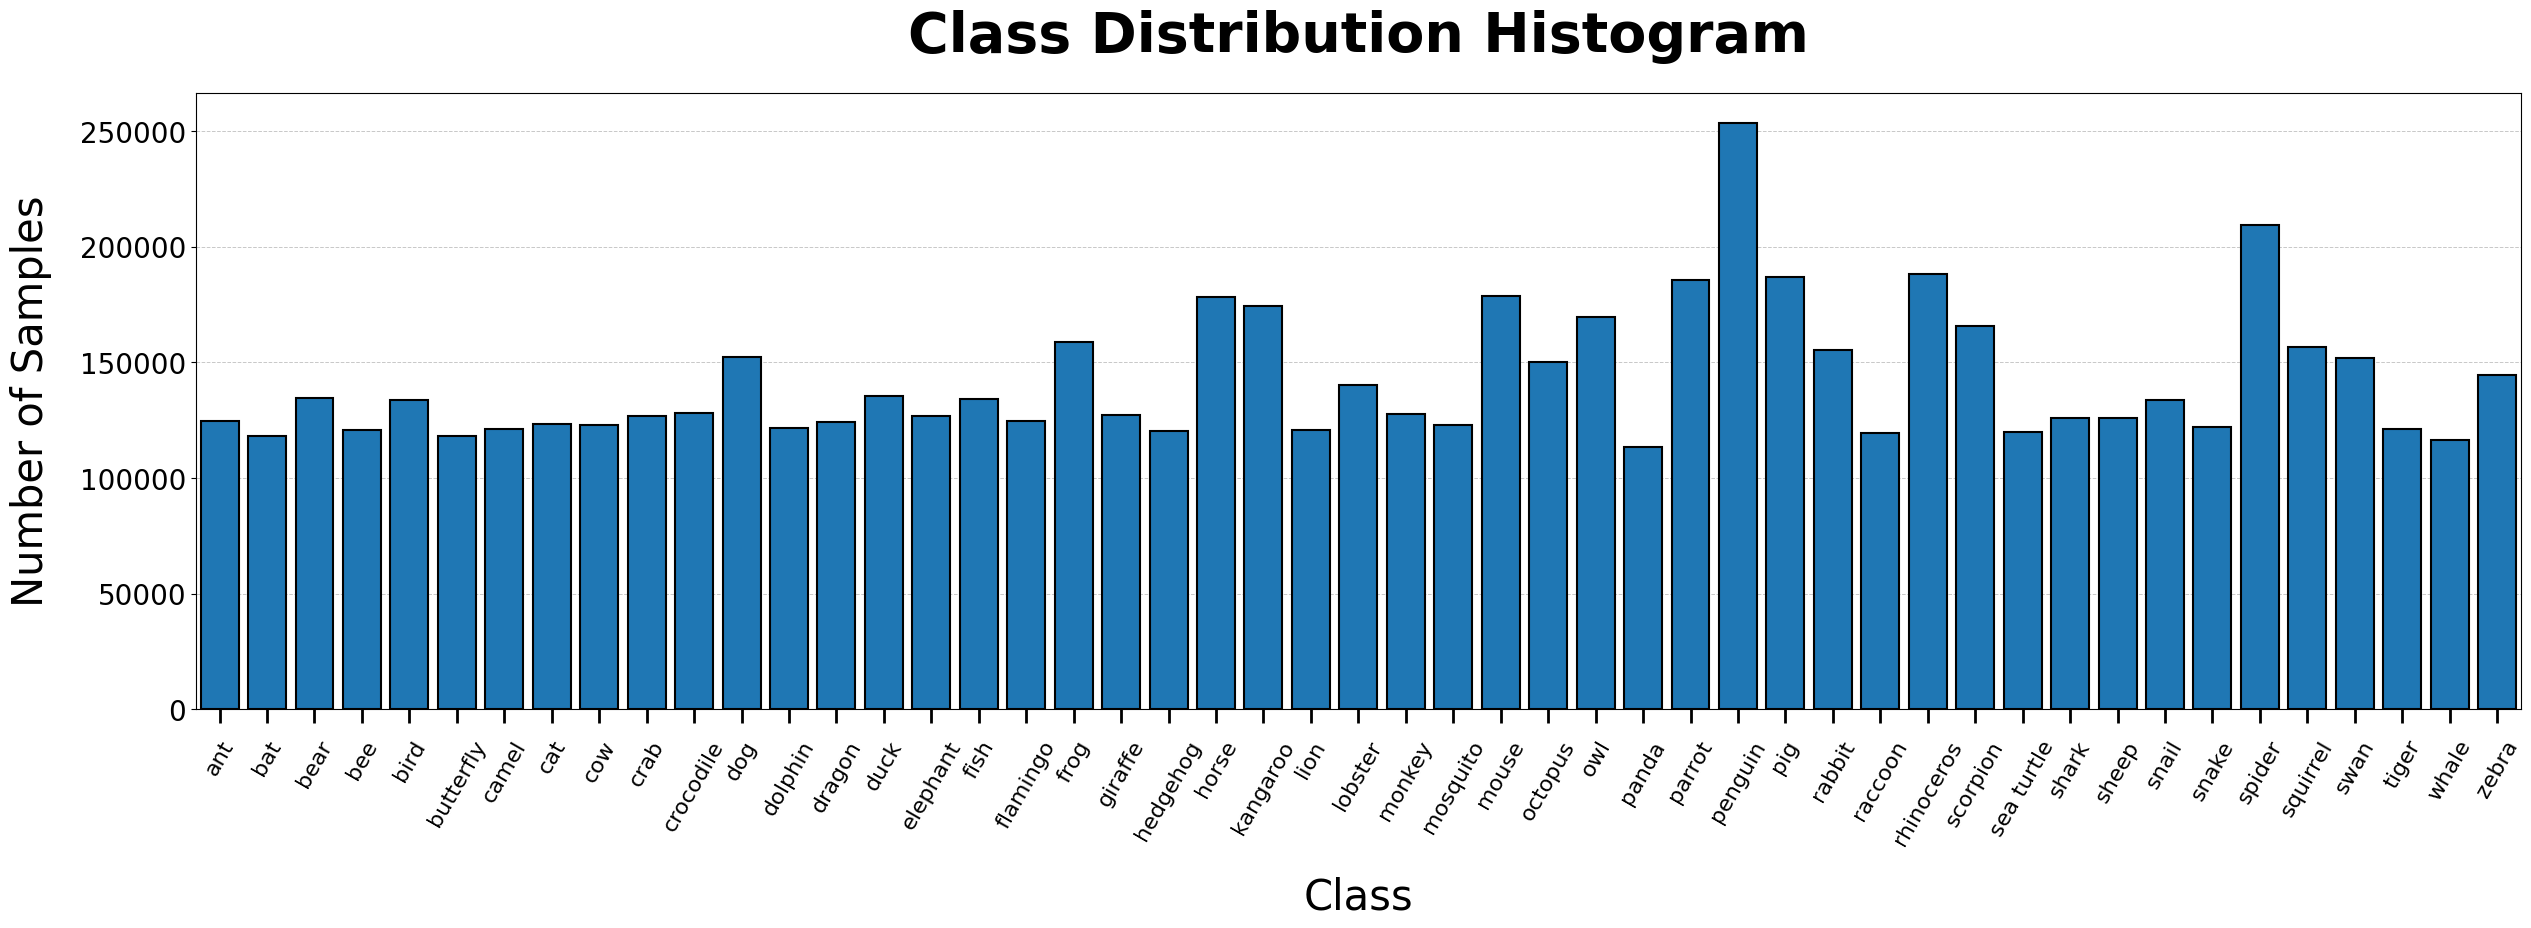

In [26]:
#Calculate class distribution
class_counts = {cls: np.sum(label_array == cls) for cls in classes}

#Create Class Histogram
fig, ax = plt.subplots(figsize=(30, 8))

#Plot Bars
ax.bar(class_counts.keys(), class_counts.values(), zorder=3, edgecolor='black', linewidth=1.5, color='#1f77b4')

#Formatting
ax.tick_params(axis='x', labelrotation=60, labelsize=16, pad=10, length=10, width=2)
ax.tick_params(axis='y', labelsize=20)
ax.set_xlim(-0.5, len(classes)-0.5)
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7, zorder=0)

#Labeling
ax.set_xlabel('Class', fontsize=30, labelpad=20)
ax.set_ylabel('Number of Samples', fontsize=30, labelpad=20)
ax.set_title('Class Distribution Histogram', fontsize=40, pad=30, weight='bold')

In [27]:
#Shuffle data and labels in unison
perm = np.random.permutation(data_array.shape[0])
data_array = data_array[perm]
label_array = label_array[perm]

#Subset data to 500k
data_array = data_array[:500_000]
label_array = label_array[:500_000]

# Custom Classes & Funcs

## Custom Dataset

In [28]:
class DoodleDataset(Dataset):
    def __init__(self, data, labels, classes, transform=None):
        #Store Parameters
        self.data = data
        self.labels = labels
        self.classes = classes
        self.transform = transform
        
        #Create Mapping to Classes
        self.class_map = {class_i: idx for idx, class_i in enumerate(self.classes)}
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].reshape(28, 28).astype(np.float32)/255.0  # Normalize pixel values
        label = self.class_map[self.labels[idx]]
        
        if self.transform:
            image = self.transform(image)
        
        image = torch.tensor(image).unsqueeze(0)  # Add channel dimension
        label = torch.tensor(label).long()
        
        return image, label

## Custom Network

In [29]:
class DoodleCNN(nn.Module):
    def __init__(self, classes):
        super(DoodleCNN, self).__init__()
        self.net = nn.Sequential(
            #Convolutional layers
            nn.Conv2d(in_channels=1,      out_channels=4,        kernel_size=(5, 5),      padding=(2, 2)),
            nn.SELU(),
            nn.Conv2d(in_channels=4,      out_channels=16,       kernel_size=(5, 5),      padding=(2, 2)),
            nn.SELU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=16,     out_channels=64,       kernel_size=(5, 5),      padding=(2, 2)),
            nn.SELU(),
            nn.Conv2d(in_channels=64,     out_channels=128,      kernel_size=(5, 5),      padding=(2, 2)),
            nn.SELU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=128,    out_channels=256,      kernel_size=(5, 5),      padding=(2, 2)),
            nn.SELU(),
            nn.Conv2d(in_channels=256,    out_channels=512,      kernel_size=(5, 5),      padding=(2, 2)),
            nn.SELU(),
            nn.MaxPool2d(2, 2),
            
            #Convert to 1D
			nn.Flatten(),
            
            #Fully connected layers
            nn.Linear(512*3*3, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, len(classes)),
             
        )

    def forward(self, x):
        x = self.net(x)
        return x

## Setup Dataloaders

In [30]:
def setup_dataloaders(data, labels, classes, val_size=0.15, test_size=0.15, batch_size=64, random_state=42):
    # Split data into Training, Validation, & Testing sets
    X_train, X_valtest, y_train, y_valtest = train_test_split(data, labels, test_size=(test_size + val_size), random_state=random_state, stratify=labels)
    X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=(test_size/(test_size + val_size)), random_state=random_state, stratify=y_valtest)

    # Setup Training, Validation, & Testing Dataloaders
    train_dataset = DoodleDataset(X_train, y_train, classes)
    val_dataset = DoodleDataset(X_val, y_val, classes)
    test_dataset = DoodleDataset(X_test, y_test, classes)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
    dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}
    return dataloaders, dataset_sizes

## Training Function

In [31]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=50):
    #Setup model history tracking
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'test_loss': None, 'test_acc': None}
    
    for epoch in range(num_epochs):
        #Training
        model.train()
        train_running_loss = 0.0
        train_running_corrects = 0
        for image, label in dataloaders['train']:
            image = image.to(device)
            label = label.to(device)
            
            outputs = model(image)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_running_loss += loss.item()*image.size(0)
            train_running_corrects += torch.sum(preds == label.data)
            
        train_epoch_loss = train_running_loss/dataset_sizes['train']
        train_epoch_acc = train_running_corrects.double()/dataset_sizes['train']
        scheduler.step()
        
        #Validation
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_running_corrects = 0
            for image, label in dataloaders['val']:
                image = image.to(device)
                label = label.to(device)
                
                outputs = model(image)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, label)
                
                val_running_loss += loss.item()*image.size(0)
                val_running_corrects += torch.sum(preds == label.data)
            
            val_epoch_loss = val_running_loss/dataset_sizes['val']
            val_epoch_acc = val_running_corrects.double()/dataset_sizes['val']
        
        #Printouts & appends
        print(f'|    Epoch:  [{epoch+1:2}]/[{num_epochs:2}]    |    '
              f'Train Loss:  [{train_epoch_loss:.4f}]    |    Train Acc:  [{train_epoch_acc:.4f}]    |    '
              f'Val Loss:  [{val_epoch_loss:.4f}]    |    Val Acc:  [{val_epoch_acc:.4f}]    |')
        history['train_loss'].append(train_epoch_loss)
        history['train_acc'].append(train_epoch_acc.item())
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.item())
        
    #Testing
    model.eval()
    with torch.no_grad():
        test_running_loss = 0.0
        test_running_corrects = 0
        for image, label in dataloaders['test']:
            image = image.to(device)
            label = label.to(device)
            
            outputs = model(image)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, label)
            
            test_running_loss += loss.item()*image.size(0)
            test_running_corrects += torch.sum(preds == label.data)
            
        test_epoch_loss = test_running_loss/dataset_sizes['test']
        test_epoch_acc = test_running_corrects.double()/dataset_sizes['test']
    
    #Printouts & appends
    print(f'Test Loss: {test_epoch_loss:.4f} Acc: {test_epoch_acc:.4f}')
    history['test_loss'] = test_epoch_loss
    history['test_acc'] = test_epoch_acc.item()
    
    return model, history

# Training

## Hyperparams

In [32]:
#Learning Params
lr = 1e-4
num_epochs = 50
delta = 0.1
test_size = 0.1
val_size = 0.2
random_state = 42
batch_size = 8192

## Train Setup and Call

In [33]:
#Setup Dataloaders
dataloaders, dataset_sizes = setup_dataloaders(data_array, label_array, classes, val_size=val_size, test_size=test_size, batch_size=batch_size, random_state=random_state)

#Training Setup
model = DoodleCNN(classes).to(device)
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=lr*delta)
trained_model, history = train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=num_epochs)

#Save Model Weights
torch.save(trained_model.state_dict(), 'doodle_cnn_model.pth')

|    Epoch:  [ 1]/[50]    |    Train Loss:  [3.5535]    |    Train Acc:  [0.0942]    |    Val Loss:  [3.1034]    |    Val Acc:  [0.1908]    |
|    Epoch:  [ 2]/[50]    |    Train Loss:  [3.0024]    |    Train Acc:  [0.2098]    |    Val Loss:  [2.7291]    |    Val Acc:  [0.2784]    |
|    Epoch:  [ 3]/[50]    |    Train Loss:  [2.6941]    |    Train Acc:  [0.2876]    |    Val Loss:  [2.4732]    |    Val Acc:  [0.3457]    |
|    Epoch:  [ 4]/[50]    |    Train Loss:  [2.4692]    |    Train Acc:  [0.3450]    |    Val Loss:  [2.2849]    |    Val Acc:  [0.3929]    |
|    Epoch:  [ 5]/[50]    |    Train Loss:  [2.3096]    |    Train Acc:  [0.3858]    |    Val Loss:  [2.1596]    |    Val Acc:  [0.4224]    |
|    Epoch:  [ 6]/[50]    |    Train Loss:  [2.1977]    |    Train Acc:  [0.4129]    |    Val Loss:  [2.0762]    |    Val Acc:  [0.4425]    |
|    Epoch:  [ 7]/[50]    |    Train Loss:  [2.1079]    |    Train Acc:  [0.4352]    |    Val Loss:  [1.9893]    |    Val Acc:  [0.4646]    |
|    E